# Rate Model of 1 Excitatory and 3 Inhibitory populations
4 Wilson-Cowan style populations with feedforward input from thalamus and recurrent connections.

Following the 2 population model in Natan et al 2015, and 4 population model in Litwin-Kumar et al 2016

Rough outline:
0. Make general model with 4x4 weight matrix
1. Set 2 of the I population weights to 0 and reproduce result from Natan

UPDATE: I'm not sure how much it is worth to try to reproduce this network, because it doesn't easily generalize to the Litwin-Kumar 4 population network. There are some weird specificities in here, like the inhibitory transfer function, and the precomputed input current and opto current. One thing that is probably useful is the synaptic adaptiation. So I'm going to skip directly to the Litwin-Kumar network here.

UPDATE 2: the rate network in Litwin-Kumar is the linearized network...

2. DONE - Reproduce steady-state 2 population result from Litwin-Kumar
3. DONE - Reproduce steady-state 4 population result from Litwin-Kumar
4. DONE Add adaptive synapses to recurrent circuit
5. Extend to reproduce experimental findings in Natan, probably need to tile the circuit

In [1]:
from scipy import integrate, signal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['font.size']=14
plt.rcParams['font.family']='Arial'
c_ord = [0,2,1,4]

In [2]:
### network architectures
def network(r, t, J, T):    
    drdt = (-r + transfer_func(mu(t) + np.dot(J,r)))/T
    return drdt

def linear_network(r, t, W, T):    
    # linearized network
    # r is a 4-D vector that represents the firing rate of the units
    drdt = (np.dot(W,r)-r + mu(t))/T
    return drdt

def network_TC_adapt(y, t, W, T, T_adapt, g0, thalamic_amp, opto_amp, opto_target, ESOM_fac):
    # network with thalamocortical adaptation
    # y represents the firing rate of the units and the adaptation variables
    # 0-3 are the unit rates; 4-5 are TC synapses for std tone (E & PV), 6-7 are for deviant, 8 is E-SOM
    r, g_std, g_dev, g_SE = y[:4], y[4:6], y[6:8], y[8]
    
    thalamic_std = time_varying_stim(I_stim_std, t,dt, r.shape[0])*thalamic_amp
    thalamic_dev = time_varying_stim(I_stim_dev, t,dt, r.shape[0])*thalamic_amp
    
    #opto = generic_step_input(t,opto_drive, opto_onset)
    # sets the amplitude and target of opto manipulation
    opto_mask = np.zeros(len(r))
    opto_mask[opto_target] = opto_amp
    opto = time_varying_stim(I_opto, t, dt, r.shape[0])*opto_mask
    
    # add together all the external input at this time step
    mu = thalamic_std*np.hstack((g_std,[0,0])) + thalamic_dev*np.hstack((g_dev,[0,0])) + opto
    
    # update synaptic adaptation variables
    #    std thalamic inputs to E/PV, dev thalamic inputs to E/PV, E rate for gSE
    #    E rate is negated to keep the same adaptation equation and flipping the sign of the depletion component
    r_pre = np.hstack((thalamic_std[:2], thalamic_dev[:2], 0))
    T_rec, T_dep = T_adapt[0,:], T_adapt[1,:]
    g = np.hstack((g_std, g_dev, g_SE))
    dgdt = (g0-g)/T_rec - (g*r_pre)/T_dep

    # multiply E rate by facilitation or not here??
    if ESOM_fac:
        # dgdt[4] = (g0[4]-g[4])/T_rec[4] + g[4]*r[0]/T_dep[4]
        dgdt[4] = (g0[4]-g[4])/T_rec[4] + r[0]/T_dep[4]
    else:
        dgdt[4] = 0

    # update rate
    drdt = (np.dot(W,r)-r + mu)/T
    # re-update SOM with facilitation term
    if ESOM_fac:
        drdt[2] = (W[2,0]*g_SE*r[0]+np.dot(W[2,1:],r[1:])-r[2]+mu[2])/T[2]
    
    # tuple all state variables 
    dydt = np.hstack((drdt,dgdt))
    return dydt

### transfer functions
def transfer_func(curr_input):
    # transfer function from current to firing rate    
    return curr_input**2

### input functions
def generic_step_input(t,v=0,t_onset=0.1):
    if t<=t_onset:
        return np.zeros_like(v)
    else:
        return v

def time_varying_stim(I_stim, t, dt, dims):
    if int(t/dt)<len(I_stim):
        return np.ones(dims)*I_stim[int(t/dt)]
    else: 
        return np.zeros(dims)

### plotting
def plot_rates(t,r,W):    
    c_ord = [0,2,1,4]
    labels = ['E','PV','SOM','VIP']
    plt.subplot(2,1,1)
    for i in range(4):
        plt.plot(t,r[:,i],color=CKEYS[c_ord[i]],label=labels[i])
        
    plt.ylabel('Firing Rate (Hz)')
    plt.legend(); sns.despine()
    
    plt.subplot(2,1,2)
    Ie, Ii = return_EI(r,W)
    plt.plot(t,Ie, 'gray', label='E Total')
    plt.plot(t,Ii, 'k', label='I Total')
    plt.xlabel('Time (s)')
    plt.ylabel('Current')
    plt.legend(); sns.despine()
    plt.tight_layout()

### analysis
def return_EI(r, W):
    # sum E and I currents
    curr = W[0,:]*r
    Ie, Ii=curr[:,0], -curr[:,1:].sum(1)
    return Ie-Ie[0],Ii-Ii[0]

def stim_trig(x, stim_times, dt, window=[-100,200]):
    # grab a window of data around the stimulus times
    stack = np.array([x[ind+window[0]:ind+window[1],:] for ind in (stim_times/dt).astype(int)])
    t_trial = np.arange(window[0],window[1])*dt
    return t_trial, stack

def SSA(DA, DB, SA, SB):
    # SSA index formula from Natan
    return (DA+DB-SA-SB)/(DA+DB+SA+SB)

def get_max_FR(r_trials):
    # get the maximum firing rate of each trial
    return np.max(r_trials, axis=1)

def rescale(x,m,M):
    return (m+(x*(M-m)))

def run_model(W, tau_neurons, T_adapt, y0, thalamic_amp, opto_amp, opto_target, ESOM_fac, inc_VIP):
    ###### 
    # time-varying thalamic input is created in the cell above and 
    # defined in the function itself.
    # not the best code but much easier since we don't change thalamic inputs

    ### run sim ###
    # the last 2 parameters set the precision bounds for the simulation steps, which is important
    # because the inputs are discrete jumps, but it makes it run slower
    W_exp = np.copy(W)
    if not inc_VIP:
        W_exp[:,-1]=0; W_exp[-1,:]=0
        
    exp_args = (W_exp, tau_neurons, T_adapt, y0[4:], thalamic_amp, opto_amp, opto_target, ESOM_fac)
    r = integrate.odeint(network_TC_adapt, y0, t, args=exp_args, tcrit=stim_times-0.1, hmax=dt*10)

    ##### analysis #####
    stim_times_std = np.where(stim_train_std)[0]*dt
    stim_times_dev = np.where(stim_train_dev)[0]*dt

    t_trial, r_trial_dev = stim_trig(r, stim_times_dev, dt)
    t_trial, r_trial_std = stim_trig(r, stim_times_std, dt)
    _, r_trial = stim_trig(r, stim_times, dt)

    # get trial peak firing rates
    trial_fr = get_max_FR(r_trial)

    # compute SSA 
    # dev_trial is the trial on which the deviant tone is presented
    # onto the other thalamocortical input
    ssa = SSA(trial_fr[0],trial_fr[dev_trial],trial_fr[dev_trial-1],trial_fr[dev_trial-1])    
    return r, t_trial, r_trial, trial_fr, ssa

### Adaptation network

In [3]:
# constructing the sound and opto stimulus
T, dt = 5, 0.001
t = np.arange(0,T,dt)
t0_stim = 1
n_pulses = 9
isi = 0.4
dev_trial = 4

stim_type = 'exp'
stim_train = np.zeros_like(t)
stim_times = np.arange(n_pulses)*isi+t0_stim
stim_train[(stim_times/dt).astype(int)] = 1

if stim_type is 'box':
    stim_dur = 0.02
    stim_single = signal.windows.boxcar(int(stim_dur/dt))
elif stim_type is 'exp':
    stim_tau = 0.025
    t_exp=np.arange(0,0.1,dt)
    stim_single = np.exp(-t_exp/stim_tau)

stim_train_std, stim_train_dev = np.zeros_like(t), np.zeros_like(t)

stim_train_dev[(stim_times[dev_trial]/dt).astype(int)] = 1
stim_train_std = stim_train - stim_train_dev

I_stim_dev = np.convolve(stim_train_dev, stim_single, mode='full')[:len(t)]
I_stim_std = np.convolve(stim_train_std, stim_single, mode='full')[:len(t)]

### opto stim train, really don't need to turn this 
# on and off but it makes for a nicer figure
opto_train = np.zeros_like(t)
opto_train[((stim_times-0.1)/dt).astype(int)] = 1
I_opto = np.convolve(opto_train, signal.windows.boxcar(int(0.25/dt)), mode='full')[:len(t)]

# Parameter Sweep

In [87]:
n_trials = 1000

# constant variables
# 1.5s for rec seems too long, see Levy & Reyes JN 2012
tau_neurons = np.array([0.02, 0.02, 0.02, 0.02]).T
T_recs = np.array([1.,1.,1.,1.,1.])
T_deps = np.array([0.02,0.02,0.02,0.02,0.02])
T_adapt = np.vstack((T_recs, T_deps))
inc_VIP = True
ESOM_fac = True

# randomly drawn variables
W_EEs = rescale(np.random.rand(n_trials), 0.5, 1.5)
W_EPs = rescale(np.random.rand(n_trials), 0.5, 1.5)
W_ESs = rescale(np.random.rand(n_trials), 0.5, 1.5)

W_PEs = rescale(np.random.rand(n_trials), 0.5, 1.5)
W_PPs = rescale(np.random.rand(n_trials), 0.5, 1.5)
W_PSs = rescale(np.random.rand(n_trials), 0.1, 1.)

W_SEs = rescale(np.random.rand(n_trials), 0.5, 1.5)
W_SVs = rescale(np.random.rand(n_trials), 0., 0.5)

W_VEs = rescale(np.random.rand(n_trials), 0.5, 1.5)
W_VSs = rescale(np.random.rand(n_trials), 0., 1.)

g_SEs = rescale(np.random.rand(n_trials), 0., 0.7)
opto_amps = -rescale(np.random.rand(n_trials), 0.1, 1.)
thalamic_amps = rescale(np.random.rand(n_trials), 0.5, 5.)


In [157]:
import pandas as pd
independents = np.array([W_EEs,W_EPs,W_ESs,W_PEs,W_PPs,W_PSs,W_SEs,W_SVs,W_VEs,W_VSs,g_SEs,opto_amps,thalamic_amps]).T
cols = ['W_EEs','W_EPs','W_ESs','W_PEs','W_PPs','W_PSs','W_SEs','W_SVs','W_VEs','W_VSs','g_SEs','opto_amps','thalamic_amps']
df_indep = pd.DataFrame(independents, columns=cols)

# collect
dependents = np.zeros((n_trials, 39))
for tr in range(n_trials):
    exp_result = []
    for exp in range(3):
        exp_result.append(np.hstack(np.array([results_all[tr][exp][3][:,0], results_all[tr][exp][4][:4]])))
    
    dependents[tr,:] = np.hstack(exp_result)

# labels
dep_cols = []
for exp in ['BL','nP', 'nS']:
    dep_cols = dep_cols+['%s_Etr_%i'%(exp,tr) for tr in range(n_pulses)]+['%s_ssa_%s'%(exp,unit) for unit in ['E','PV','SOM','VIP']]

df_dep = pd.DataFrame(dependents, columns=dep_cols)
df_all = pd.concat((df_indep, df_dep), axis=1)
df_all.to_csv('../data/exp_1.csv')

In [88]:
results_all = []
for tr in range(n_trials):
    print(tr,end='|')
    W = np.array([[W_EEs[tr], -W_EPs[tr], -W_ESs[tr], 0],
                  [W_PEs[tr], -W_PPs[tr], -W_PSs[tr], 0],
                  [W_SEs[tr], 0, 0, -W_SVs[tr]],
                  [W_VEs[tr], 0, -W_VSs[tr], 0]])

    g0 = np.array([1., 1., 1., 1., g_SEs[tr]])
    opto_amp = opto_amps[tr]
    thalamic_amp = thalamic_amps[tr]

    # initial cond
    y0 = np.hstack((np.zeros(len(tau_neurons)),g0))
    collect = (run_model(W, tau_neurons, T_adapt, y0, thalamic_amp, 0, 0, ESOM_fac, inc_VIP),
              run_model(W, tau_neurons, T_adapt, y0, thalamic_amp, opto_amp, 1, ESOM_fac, inc_VIP),
              run_model(W, tau_neurons, T_adapt, y0, thalamic_amp, opto_amp, 2, ESOM_fac, inc_VIP))
    results_all.append(collect)

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|

/Users/rdgao/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91|92|93|94|95|96|97|98|99|100|101|102|103|104|105|106|107|108|109|110|111|112|113|114|115|116|117|118|119|120|121|122|123|124|125|126|127|128|129|130|131|132|133|134|135|136|137|138|139|140|141|142|143|144|145|146|147|148|149|150|151|152|153|154|155|156|157|158|159|160|161|162|163|164|165|166|167|168|169|170|171|172|173|174|175|176|177|178|179|180|181|182|183|184|185|186|187|188|189|190|191|192|193|194|195|196|197|198|199|200|201|202|203|204|205|206|207|208|209|210|211|212|213|214|215|216|217|218|219|220|221|222|223|224|225|226|227|228|229|230|231|232|233|234|235|236|237|238|239|240|241|242|243|244|245|246|247|248|249|250|251|252|253|254|255|256|257|258|259|260|261|262|263|264|265|266|267|268|269|270|271|272|273|274|275|276|277|278|279|280|281|282|283|284|285|286|287|288|289|290|291|292|293|294|295|296|297|298|299|300|301|302|303|304|305|306|307|308|309|310|311|312|313|314|315|316|317|31

(10, 3, 9)

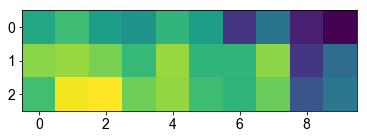

In [81]:
plt.imshow(fr_all[:,:,0].T)
fr_all.shape

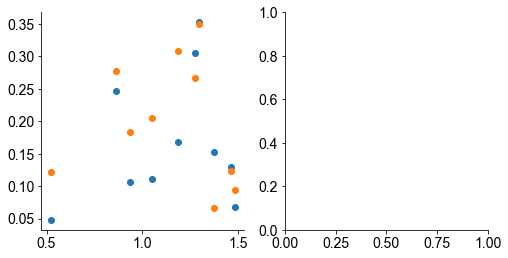

In [84]:
x_feat = W_EEs
fr_all = np.array([[exp[3][0] for exp in results_all[tr]] for tr in range(n_trials)])
ssa_all = np.array([[exp[4][0] for exp in results_all[tr]] for tr in range(n_trials)])
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(x_feat, fr_all[:,1,0]-fr_all[:,0,0], 'o', label='NoPV-E')
plt.plot(x_feat, fr_all[:,2,0]-fr_all[:,0,0], 'o', label='NoSOM-E')
plt.subplot(1,2,2)

sns.despine()

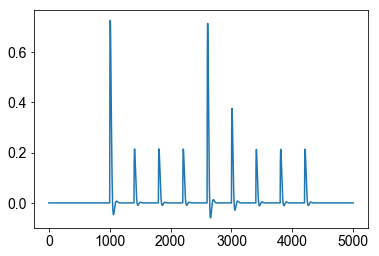

In [73]:
plt.plot(results_all[0][0][0][:,1])

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


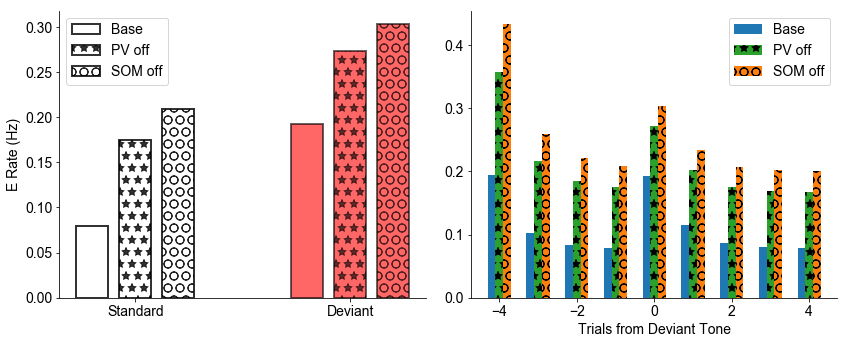

In [9]:
plt.figure(figsize=(12,5))
textures = [None, '*', 'O']
labels=['Base', 'PV off', 'SOM off']
bar_offset = 0.2
for r_i, res in enumerate([res_baseline, res_optoPV, res_optoSOM]):
    plt.subplot(1,2,1)
    plt.bar(0+bar_offset*(r_i-1), res[3][dev_trial-1,0], linewidth=2, width=0.15, edgecolor='k', color='w', alpha=0.8, hatch=textures[r_i], label=labels[r_i])
    plt.bar(1+bar_offset*(r_i-1), res[3][dev_trial,0], linewidth=2, width=0.15, edgecolor='k', color='r', alpha=0.6, hatch=textures[r_i])
    
    plt.subplot(1,2,2)
    plt.bar(np.arange(len(stim_times))+bar_offset*(r_i-1)-dev_trial, res[3][:,0], width=0.2, hatch=textures[r_i], color=CKEYS[c_ord[r_i]], label=labels[r_i])

plt.legend(); plt.xlabel('Trials from Deviant Tone')

plt.subplot(1,2,1)
sns.despine(); plt.tight_layout()
plt.ylabel('E Rate (Hz)')
plt.xticks([0, 1], ['Standard', 'Deviant'])
plt.legend(); plt.tight_layout()

# Single Run

In [9]:
##### parameter definitions
r0 = np.array([4,9,5,3]).T
W_EE = 1.2
# w_ij is j to i
W = np.array([[W_EE, -1, -1, 0],
              [1, -1, -0.5, 0],
              [1, 0, 0, -0.25],
              [1, 0, -0.6, 0]])

# adaptation variables
# 1.5s for rec seems too long, see Levy & Reyes JN 2012
T_recs = np.array([1.,1.,1.,1.,1.])
T_deps = np.array([0.02,0.02,0.02,0.02,0.02])
T_adapt = np.vstack((T_recs, T_deps))
g0 = np.array([1., 1., 1., 1., 0.2])
tau_neurons = np.array([0.02, 0.02, 0.02, 0.02]).T

# thalamic & opto inputs
opto_amp = -0.2
opto_target = 2 # 1 for PV, 2 for SOM
thalamic_amp = 1.

# set VIP outgoing weights to 0
inc_VIP = True
ESOM_fac = True

# initial cond
y0 = np.hstack((np.zeros(len(tau_neurons)),g0))

In [7]:
thalamic_amp = 2.
ESOM_fac = True
inc_VIP = True

opto_amp = 0
opto_target = 1
res_baseline = run_model(W, tau_neurons, T_adapt, y0, thalamic_amp, opto_amp, opto_target, ESOM_fac, inc_VIP)

opto_amp = -0.5
opto_target = 1
res_optoPV = run_model(W, tau_neurons, T_adapt, y0, thalamic_amp, opto_amp, opto_target, ESOM_fac, inc_VIP)

opto_amp = -0.5
opto_target = 2
res_optoSOM = run_model(W, tau_neurons, T_adapt, y0, thalamic_amp, opto_amp, opto_target, ESOM_fac, inc_VIP)

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


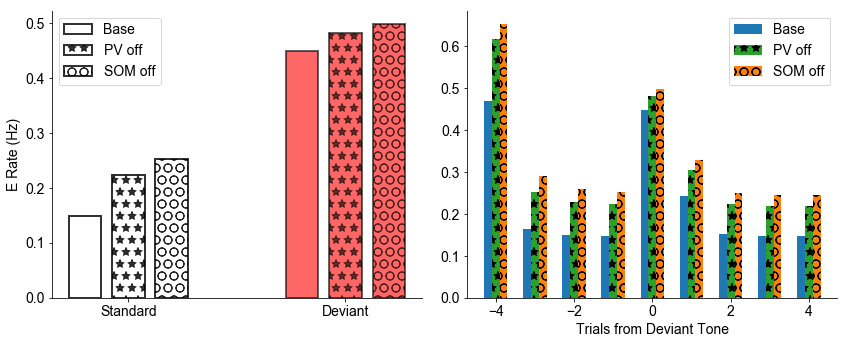

In [8]:
plt.figure(figsize=(12,5))
textures = [None, '*', 'O']
labels=['Base', 'PV off', 'SOM off']
bar_offset = 0.2
for r_i, res in enumerate([res_baseline, res_optoPV, res_optoSOM]):
    plt.subplot(1,2,1)
    plt.bar(0+bar_offset*(r_i-1), res[3][dev_trial-1,0], linewidth=2, width=0.15, edgecolor='k', color='w', alpha=0.8, hatch=textures[r_i], label=labels[r_i])
    plt.bar(1+bar_offset*(r_i-1), res[3][dev_trial,0], linewidth=2, width=0.15, edgecolor='k', color='r', alpha=0.6, hatch=textures[r_i])
    
    plt.subplot(1,2,2)
    plt.bar(np.arange(len(stim_times))+bar_offset*(r_i-1)-dev_trial, res[3][:,0], width=0.2, hatch=textures[r_i], color=CKEYS[c_ord[r_i]], label=labels[r_i])

plt.legend(); plt.xlabel('Trials from Deviant Tone')

plt.subplot(1,2,1)
sns.despine(); plt.tight_layout()
plt.ylabel('E Rate (Hz)')
plt.xticks([0, 1], ['Standard', 'Deviant'])
plt.legend(); plt.tight_layout()

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


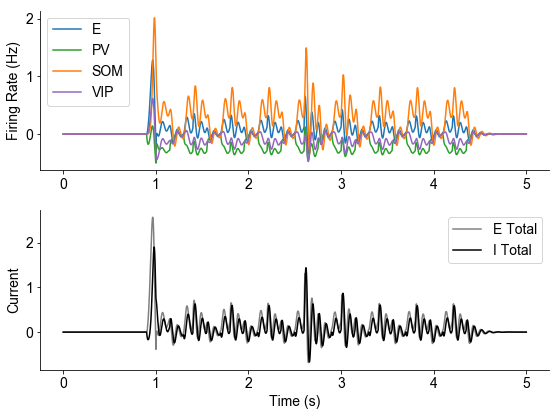

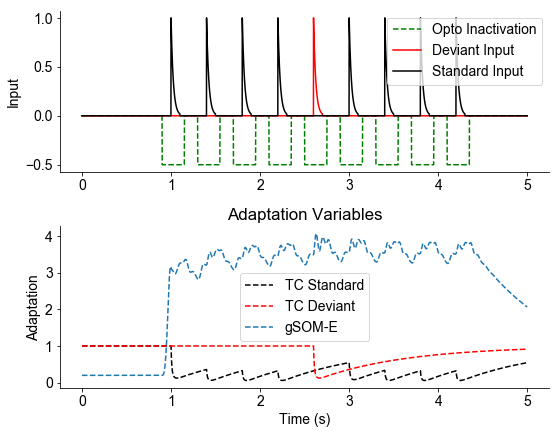

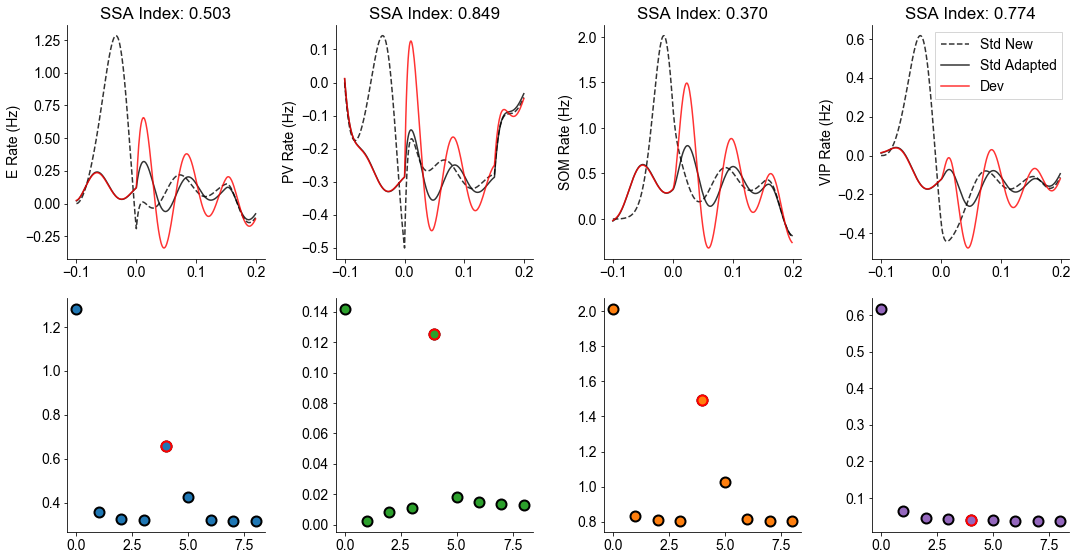

In [97]:
r, t_trial, r_trial, trial_fr, ssa = res_optoPV
plt.figure(figsize=(8,6))
plot_rates(t,r[:,:4], W)

plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(t, I_opto*opto_amp, 'g--', label='Opto Inactivation')
plt.plot(t,I_stim_dev, 'r', label='Deviant Input')
plt.plot(t,I_stim_std, 'k', label='Standard Input')
plt.ylabel('Input'); sns.despine(); plt.legend()
#plt.xlim([0.9, 1.2])

plt.subplot(2,1,2)
plt.plot(t,r[:,4], 'k--', label='TC Standard')
plt.plot(t,r[:,6], 'r--', label='TC Deviant')
plt.plot(t,r[:,8], '--', label='gSOM-E')
plt.title('Adaptation Variables'); plt.legend(); sns.despine()
plt.tight_layout()
plt.xlabel('Time (s)'); plt.ylabel('Adaptation');

## 
c_ord = [0,2,1,4]
labels = ['E','PV','SOM','VIP']
plt.figure(figsize=(15,8))
for unit in range(4):
    plt.subplot(2,4,unit+1)
    plt.plot(t_trial, r_trial[0,:,unit], 'k--', alpha=0.8, label='Std New')
    plt.plot(t_trial, r_trial[dev_trial-1,:,unit], 'k', alpha=0.8, label='Std Adapted')
    plt.plot(t_trial, r_trial[dev_trial,:,unit], 'r', alpha=0.8, label='Dev')
    plt.ylabel('%s Rate (Hz)'%labels[unit])
    plt.title('SSA Index: %.3f'%(ssa[unit]))
    
    plt.subplot(2,4,4+unit+1)
    plt.plot(trial_fr[:,unit], 'o', ms=10, mew=2, mec='k', color=CKEYS[c_ord[unit]])
    plt.plot(dev_trial, trial_fr[dev_trial,unit], 'o', ms=10, mew=2, mec='r', color=CKEYS[c_ord[unit]])
    
plt.tight_layout(); sns.despine()
plt.subplot(2,4,4)
plt.legend(fancybox=False);

### No adaptation

In [151]:
# r0 = np.array([4,9,5,3]).T
# T, dt = 0.4, 0.001
# t = np.arange(0,T,dt)
# W_EE = 1.2
# W = np.array([[W_EE, -1, -1, 0],
#               [1, -1, -0.5, 0],
#               [1, 0, 0, -0.25],
#               [1, 0, -0.6, 0]])

# tau_neurons = np.array([0.02, 0.02, 0.02, 0.02]).T

# thalamic_drive = np.array([1,1,0,0]).T
# thalamic_onset = 0.2

# opto_drive = np.array([0,0,0,5]).T
# opto_onset = 0.1

# r = integrate.odeint(linear_network, np.zeros(4), t, args=(W, tau_neurons))
# plt.figure(figsize=(8,6))
# plot_rates(t,r+r0, W)